<a href="https://colab.research.google.com/github/JingwenLuo7/Multi-Omics_Modelling_Glioma/blob/main/code/BatchCorrection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

filepath="/content/drive/MyDrive/DSLS_project/4.5_BatchCorrection/"

shared_path = "/content/drive/Shared drives/4_feature_filtering"


Mounted at /content/drive


In [3]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
!pip install neuroCombat
from neuroCombat import neuroCombat
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import numpy as np

  Preparing metadata (setup.py) ... done
  Created wheel for neuroCombat: filename=neuroCombat-0.2.12-py3-none-any.whl size=6353 sha256=f6fa218c8039319bf12bf472667e016f4ee131772d387e90b1e8f8d5e5e940c1
  Stored in directory: /root/.cache/pip/wheels/b0/f8/c9/375ca529543b8b0a6abc4d9243e8d951209220c1a6dc892f24
Successfully built neuroCombat


## Batch correction for TCGA-GBM 27 VS 450

In [4]:
## load data

source = ["train","val","external_test","internal_test"]

data_GBM = {}
for s in source:
  # Use index_col=0 to set the first column as the index
  df = pd.read_csv(filepath + '/TCGA_GBM_mval_methylation_'+ s + '.csv', index_col=0)
  df_filled = df.fillna(0)
  data_GBM[s] = df_filled


In [5]:
meta_file = pd.read_csv(filepath + '/TCGA_GBM_batch_methylation.csv', index_col=0)

meta_file[:5]

,platform
sample,
TCGA-27-2521-01A,HM27
TCGA-32-4208-01A,HM27
TCGA-32-1987-01A,HM27
TCGA-12-1089-01A,HM27
TCGA-16-0848-01A,HM27


In [6]:
## batch correction for train_data
def combat_train(train_data,train_meta,output_path,
                 batch_col='platform',
                 save_estimates=True):
  combat_result = neuroCombat(
      dat=train_data,
      covars=train_meta,
      batch_col=batch_col
  )

  train_corrected = combat_result['data']
  train_corrected = pd.DataFrame(
    combat_result["data"],
    index=train_data.index,
    columns=train_data.columns
  )
  train_corrected = train_corrected.fillna(train_corrected.mean(axis=1), axis=0)
  estimates = combat_result['estimates']
  ## save parameters
  if save_estimates:
      with open(output_path+"/combat_estimates.pkl", "wb") as f:
          pickle.dump(estimates, f)

  return train_corrected

## batch correction for test_data(doesn't work)
def combat_test(test_data, test_meta,output_path,
                batch_col='platform'):
    ## read parameters
    estimates_path=output_path+'/combat_estimates.pkl'
    with open(estimates_path, "rb") as f:
        estimates = pickle.load(f)

    test_corrected = neuroCombat(
        dat=test_data,
        covars=test_meta,
        batch_col=batch_col,
        estimates=estimates
    )['data']

    return test_corrected


In [7]:
def combat_apply_from_estimates(test_data, test_meta, batch_col="platform",estimates=filepath+"/combat_estimates.pkl"):

    with open(estimates, "rb") as f:
        estimates = pickle.load(f)

    stand_mean = pd.Series(np.ravel(estimates['stand.mean']), index=test_data.index)
    grand_mean = pd.Series(np.ravel(estimates['grand.mean']), index=test_data.index)
    var_pooled = pd.Series(np.ravel(estimates['var.pooled']), index=test_data.index)

    gamma_star = pd.DataFrame(estimates['gamma.star'], index=estimates['batch_levels'], columns=test_data.index)
    delta_star = pd.DataFrame(estimates['delta.star'], index=estimates['batch_levels'], columns=test_data.index)


    batches = test_meta.loc[test_data.columns, batch_col].values
    unique_batches = gamma_star.index
    batch_map = {b: i for i, b in enumerate(unique_batches)}

    s_data = (test_data.sub(stand_mean, axis=0)).div(np.sqrt(var_pooled), axis=0)

    adjusted = pd.DataFrame(index=test_data.index, columns=test_data.columns)
    for sample in test_data.columns:
        b = test_meta.loc[sample, batch_col]
        gamma = gamma_star.loc[b]
        delta = delta_star.loc[b]
        adjusted[sample] = (s_data[sample] - gamma) / np.sqrt(delta)

    test_corrected = adjusted.mul(np.sqrt(var_pooled), axis=0).add(grand_mean, axis=0)

    return test_corrected

In [8]:
import matplotlib.gridspec as gridspec
## Plot PCA & Silhouette score
def evaluate_correction(train, train_cor, metadata, batch_col, output_path=None, title=None):
    metadata = metadata.loc[train.columns]

    pca_train = PCA(n_components=2)
    coords_train = pca_train.fit_transform(train.T)

    pca_corr = PCA(n_components=2)
    coords_corr = pca_corr.fit_transform(train_cor.T)

    # batch label
    batches = metadata[batch_col].values

    # Silhouette score
    silhouette_scores = {}
    coords_train_score = StandardScaler().fit_transform(train.T)
    coords_corr_score = StandardScaler().fit_transform(train_cor.T)

    score_train = silhouette_score(coords_train_score, batches)
    score_corr = silhouette_score(coords_corr_score, batches)

    silhouette_scores["Before"] = score_train
    silhouette_scores["After"] = score_corr

    # Plot
    fig = plt.figure(figsize=(15, 5))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1.2, 1.2, 0.6])

    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    ax3 = fig.add_subplot(gs[2])
    axes = [ax1, ax2, ax3]

    for i, (coords, label) in enumerate(zip([coords_train, coords_corr], ["Before", "After"])):
        ax = axes[i]
        for b in np.unique(batches):
            idx = np.where(batches == b)[0]
            ax.scatter(coords[idx, 0], coords[idx, 1], label=b, alpha=0.7)
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.set_title(f"{label} Batch Correction")
        ax.legend()

    # Bar plot
    axes[2].bar(silhouette_scores.keys(), silhouette_scores.values(), color='skyblue')
    axes[2].set_ylabel("Silhouette Score")
    axes[2].set_title("Silhouette Comparison")

    plt.suptitle(title or "Batch Correction PCA Evaluation")
    plt.tight_layout()
    if output_path:
        plt.savefig(output_path, dpi=300)
    plt.show()
    plt.close()


In [9]:
import pickle

with open(filepath+"/combat_estimates.pkl", "rb") as f:
    estimates = pickle.load(f)


for k, v in estimates.items():
    print(f"{k}: {type(v)}, shape = {np.shape(v)}")


gamma_hat: <class 'numpy.ndarray'>, shape = (2, 19489)
delta_hat: <class 'list'>, shape = (2, 19489)
gamma_bar: <class 'numpy.ndarray'>, shape = (2,)
t2: <class 'numpy.ndarray'>, shape = (2,)
a_prior: <class 'list'>, shape = (2,)
b_prior: <class 'list'>, shape = (2,)
batches: <class 'numpy.ndarray'>, shape = (2,)
var.pooled: <class 'numpy.ndarray'>, shape = (19489, 1)
stand.mean: <class 'numpy.ndarray'>, shape = (19489, 71)
mod.mean: <class 'numpy.ndarray'>, shape = (19489, 71)
gamma.star: <class 'numpy.ndarray'>, shape = (2, 19489)
delta.star: <class 'numpy.ndarray'>, shape = (2, 19489)


### Result

[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data


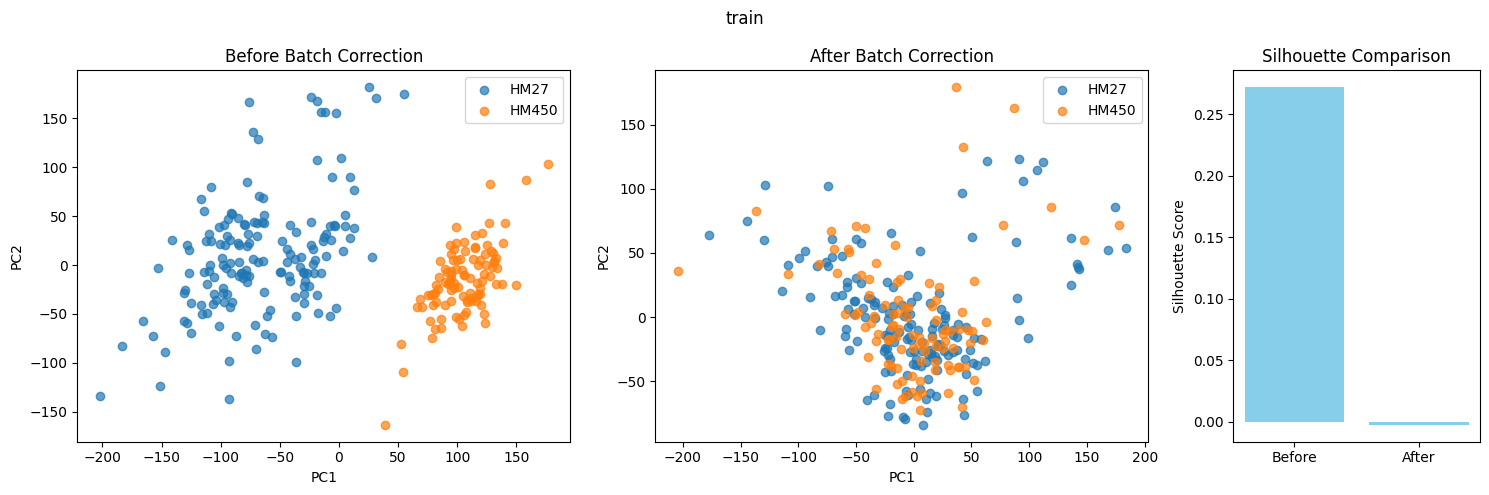

[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data


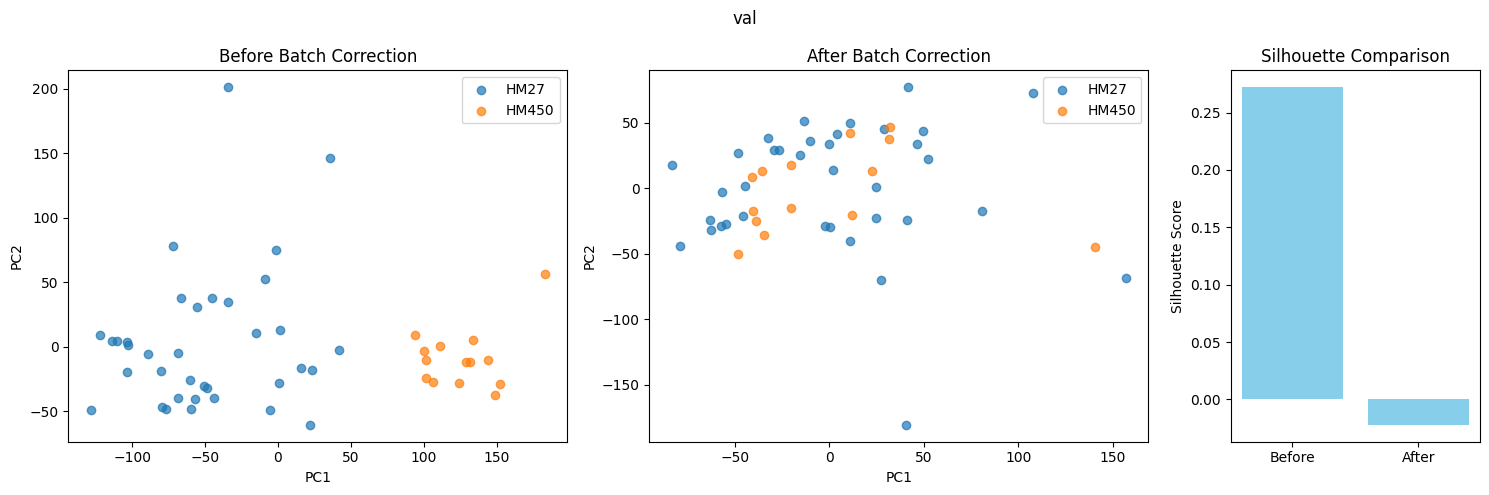

[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data


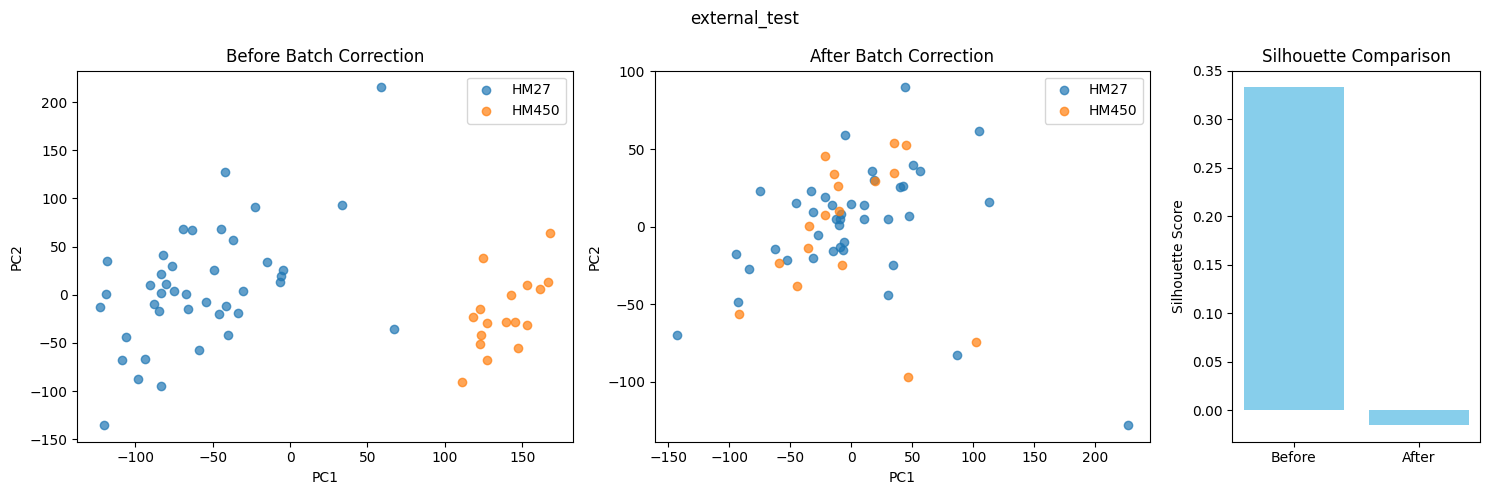

[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data


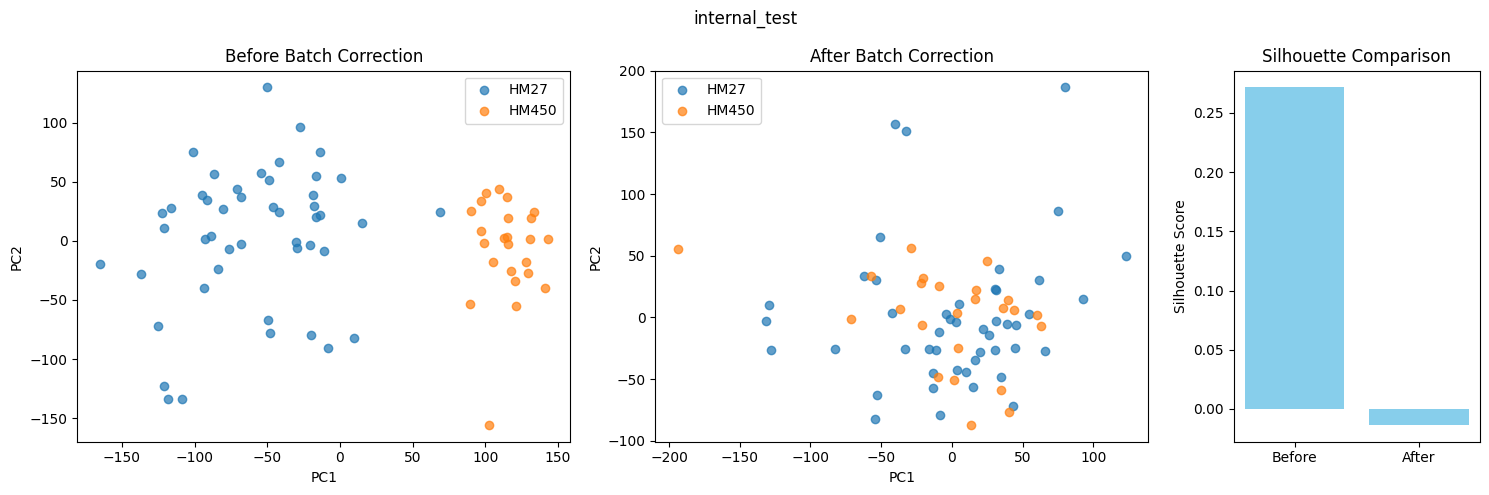

In [11]:
'''
results_GBM = {}
train_data = data_GBM['train']
train_id = data_GBM['train'].columns
train_meta = meta_file.loc[train_id]

train_corrected = combat_train(train_data,train_meta,filepath)
evaluate_correction(train_data,train_corrected, train_meta, batch_col="platform",title="Train")
'''
for k in source:
  #if k != "Train":
  test_data = data_GBM[k]
  test_id = data_GBM[k].columns
  test_meta = meta_file.loc[test_id]

  test_corrected = combat_train(test_data,test_meta,filepath)
  evaluate_correction(test_data,test_corrected, test_meta, batch_col="platform",title=k)

  test_corrected.to_csv(filepath + '/TCGA_GBM_mval_methylation_'+ k + '_corrected.csv')

  #test_corrected = combat_apply_from_estimates(test_data, test_meta)
  #evaluate_correction(test_data,test_corrected, test_meta, batch_col="platform",title=k)


In [10]:
## load data

group = ["GBM","LGG"]
omics_layer = ["SNV","CNV","methylation","protein","rna_seq"]
source = ["train","val","external_test","internal_test"]

## Batch correction for TCGA-GBM VS TCGA-LGG